In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sdv.single_table import CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer
from sdv.metadata import Metadata

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4060 Ti


In [3]:
df = pd.read_csv("../data/wustl/wustl-ehms-2020_with_attacks_categories.csv")
df.head()

,Dir,Flgs,SrcAddr,DstAddr,Sport,Dport,SrcBytes,DstBytes,SrcLoad,DstLoad,...,Temp,SpO2,Pulse_Rate,SYS,DIA,Heart_rate,Resp_Rate,ST,Attack Category,Label
0,->,e,10.0.1.172,10.0.1.150,58059,1111,496,186,276914.0,92305.0,...,28.9,0,0,0,0,0,0,0.0,normal,0
1,->,e,10.0.1.172,10.0.1.150,58062,1111,496,186,230984.0,76995.0,...,28.9,0,0,0,0,78,17,0.4,normal,0
2,->,e,10.0.1.172,10.0.1.150,58065,1111,496,186,218470.0,72823.0,...,28.9,89,104,0,0,78,17,0.4,normal,0
3,->,e,10.0.1.172,10.0.1.150,58067,1111,496,186,203376.0,67792.0,...,28.9,89,104,0,0,79,17,0.4,normal,0
4,->,e,10.0.1.172,10.0.1.150,58069,1111,496,186,235723.0,78574.0,...,28.9,89,101,0,0,79,17,0.4,normal,0


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Dport,16318.0,1111.000000,0.000000,1111.000000,1111.000000,1111.000000,1111.000000,1.111000e+03
SrcBytes,16318.0,496.650264,28.584642,310.000000,496.000000,496.000000,496.000000,2.298000e+03
DstBytes,16318.0,187.077706,18.688525,120.000000,186.000000,186.000000,186.000000,8.820000e+02
SrcLoad,16318.0,211840.633005,79429.880071,0.000000,199053.500000,236679.000000,261557.000000,1.134000e+06
DstLoad,16318.0,71024.354940,45308.106133,507.447000,66355.000000,78893.000000,87193.000000,3.938000e+06
SrcGap,16318.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
DstGap,16318.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
SIntPkt,16318.0,10.946755,101.230484,0.875000,3.792667,4.191333,4.984167,9.497338e+03
DIntPkt,16318.0,8.515423,52.504560,0.730500,2.226000,2.562250,3.136375,2.445732e+03
SIntPktAct,16318.0,1.286918,62.123452,0.000000,0.000000,0.000000,0.000000,3.002812e+03


In [5]:
df.describe(include='object').T

,count,unique,top,freq
Dir,16318,1,->,16318
Flgs,16318,7,e,15237
SrcAddr,16318,1,10.0.1.172,16318
DstAddr,16318,1,10.0.1.150,16318
Sport,16318,16314,64273,2
SrcMac,16318,2,84:3a:4b:0f:5b:94,14272
DstMac,16318,1,b8:ca:3a:cf:0b:87,16318
Attack Category,16318,3,normal,14272


In [6]:
from typing import Any

def load_and_clean_data(filepath: str) -> pd.DataFrame:
    """
    Load the dataset and perform initial cleaning.
    - Drop constant or irrelevant features.
    - Assumes 'Label' column is already binary.
    """
    df = pd.read_csv(filepath)

    # Drop columns with a single unique value or not useful for modeling
    cols_to_drop = ['Dir', 'SrcAddr', 'DstAddr', 'DstMac', 'SrcGap', 'DstGap', 
                    'DIntPktAct', 'Attack Category']  # última só se ainda existir
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df

def define_feature_sets(df: pd.DataFrame) -> dict[str, list[str]]:
    """
    Define feature subsets: biometric, network, combined.
    """
    bio_features = ['Temp', 'SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST']
    net_features = [col for col in df.select_dtypes(include='number').columns 
                    if col not in bio_features + ['Label']]

    return {
        'bio': bio_features,
        'net': net_features,
        'combined': bio_features + net_features
    }

def preprocess_and_split(df: pd.DataFrame, features: list[str]) -> tuple[np.ndarray, ...]:
    """
    Split into train/test and apply SMOTE to training data.
    """
    X = df[features].values
    y = df['Label'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    return X_train_resampled, X_test, y_train_resampled, y_test

def train_models(X_train, y_train) -> dict[str, Any]:
    """
    Train multiple classifiers and return them.
    """
    models = {
        'RF': RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=2, p=4),
        'SVM': SVC(kernel='linear', probability=True, random_state=42),
        'ANN': MLPClassifier(hidden_layer_sizes=(40, 40, 20, 10, 10, 10, 10), max_iter=500, random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)

    return models
    
def evaluate_models(models, X_test, y_test) -> None:
    """
    Evaluate all models and plot ROC curves.
    """
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)

        print(f"{name} -> Accuracy: {acc:.4f}, AUC: {auc:.4f}")

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Load data
df = load_and_clean_data("../data/wustl/wustl-ehms-2020_with_attacks_categories.csv")

# Define feature sets
feature_sets = define_feature_sets(df)

In [8]:
# Test each feature set
#for feature_type in ['bio', 'net', 'combined']:
#    print(f"\n====== Evaluating feature set: {feature_type.upper()} ======")
    
    # Preprocessing and splitting
#    X_train, X_test, y_train, y_test = preprocess_and_split(df, feature_sets[feature_type])

    # Train models
#    models = train_models(X_train, y_train)

    # Evaluate models
#    evaluate_models(models, X_test, y_test)

In [9]:
def generate_synthetic_samples(model, n_samples: int):
    """
    Generate synthetic samples and split into X, y.
    """
    df_synth = model.sample(n_samples)
    y_synth = df_synth["Label"].values
    X_synth = df_synth.drop(columns=["Label"]).values
    return X_synth, y_synth

def train_gan_model(df: pd.DataFrame, metadata: Metadata, model_type: str, epochs: int = 300):
    """
    Train a tabular generative model using SDV's Synthesizers.
    """
    models = {
        'ctgan': CTGANSynthesizer(metadata=metadata, epochs=epochs),
        'tvae': TVAESynthesizer(metadata=metadata, epochs=epochs),
        'copulagan': CopulaGANSynthesizer(metadata=metadata)
    }
    model = models[model_type.lower()]
    model.fit(df)
    return model

def evaluate_generative_model(df_train: pd.DataFrame, X_test, y_test, metadata: Metadata, model_type: str, n_samples: int = 1000):
    print(f"\n=== {model_type.upper()} ===")
    
    model = train_gan_model(df_train, metadata, model_type)
    X_synth, y_synth = generate_synthetic_samples(model, n_samples)

    models = train_models(X_synth, y_synth)
    evaluate_models(models, X_test, y_test)

In [10]:
# df: dataframe completo já limpo
# features: lista com nomes das colunas (excluindo 'Label')
# Split nos dados reais
X = df[feature_sets['combined']].values
y = df['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Recriar dataframe para GANs
df_train = pd.DataFrame(X_train, columns=feature_sets['combined'])
df_train['Label'] = y_train

In [11]:
# metadata = Metadata.detect_from_dataframe(
#     data=df_train,
#     table_name='intrusion_data',
#     infer_sdtypes=True,
#     infer_keys='primary_only'
# )
# metadata.save_to_json("intrusion_metadata.json")


=== CTGAN ===
RF -> Accuracy: 0.9252, AUC: 0.7993
KNN -> Accuracy: 0.8827, AUC: 0.6607
SVM -> Accuracy: 0.9213, AUC: 0.7534
ANN -> Accuracy: 0.8027, AUC: 0.7449


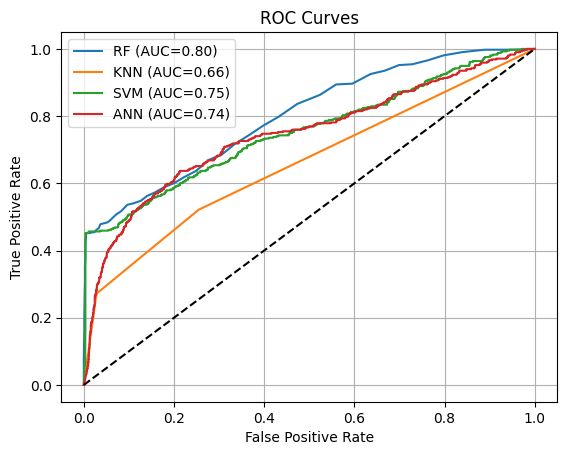


=== TVAE ===
RF -> Accuracy: 0.9252, AUC: 0.7328
KNN -> Accuracy: 0.9001, AUC: 0.6987
SVM -> Accuracy: 0.9164, AUC: 0.7607
ANN -> Accuracy: 0.8992, AUC: 0.7528


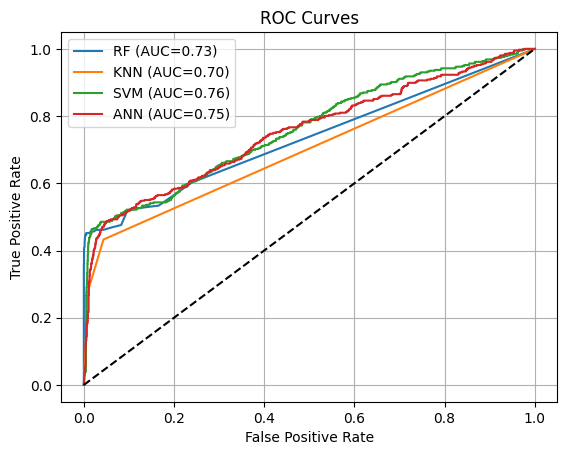


=== COPULAGAN ===


In [ ]:
metadata = Metadata.load_from_json("intrusion_metadata.json")
# Avaliar os três modelos
for model_type in ['ctgan', 'tvae', 'copulagan']:
    evaluate_generative_model(df_train, X_test, y_test, metadata, model_type)